In [1]:
import sys, os
import h2o
from h2o.estimators.deepwater import H2ODeepWaterEstimator
import os.path
from IPython.display import Image, display, HTML
import pandas as pd
import random

PATH=os.path.expanduser("~/h2o-3/")
h2o.init(nthreads=-1)
if not H2ODeepWaterEstimator.available(): exit

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,04 secs
H2O cluster version:,3.11.0.99999
H2O cluster version age:,9 hours and 42 minutes
H2O cluster name:,arno
H2O cluster total nodes:,1
H2O cluster free memory:,13.96 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


## Data Ingest
#### Image dataset
For simplicity, H2O Deep Water allows you to specify a list of URIs (file paths) or URLs (links) to images, together with a response column (either a class membership (enum) or regression target (numeric)).

For this example, we use this simple cat/dog/mouse dataset that has a few hundred images, and a label of cardinality 3.

In [2]:
frame = h2o.import_file(PATH + "/bigdata/laptop/deepwater/imagenet/cat_dog_mouse.csv")
print(frame.dim)
print(frame.head(5))

Parse progress: |█████████████████████████████████████████████████████████| 100%
[267, 2]


C1,C2
bigdata/laptop/deepwater/imagenet/cat/102194502_49f003abd9.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/11146807_00a5f35255.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1140846215_70e326f868.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/114170569_6cbdf4bbdb.jpg,cat
bigdata/laptop/deepwater/imagenet/cat/1217664848_de4c7fc296.jpg,cat


Let's look at a random subset of 10 images

['bigdata/laptop/deepwater/imagenet/dog/125896862_aea45a18ee.jpg', 'bigdata/laptop/deepwater/imagenet/cat/Bombay_Cat_-_Head.jpg', 'bigdata/laptop/deepwater/imagenet/cat/140927280_7f06e7d500.jpg', 'bigdata/laptop/deepwater/imagenet/dog/143630121_584a901cb5.jpg', 'bigdata/laptop/deepwater/imagenet/dog/30343979_1cd6a0a3dd.jpg', 'bigdata/laptop/deepwater/imagenet/cat/cicero3.jpg', 'bigdata/laptop/deepwater/imagenet/cat/1244562192_35becd66bd.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/486879767_8cc52176cf.jpg', 'bigdata/laptop/deepwater/imagenet/cat/1435339320_c78791ddb7.jpg', 'bigdata/laptop/deepwater/imagenet/mouse/315165014_6f2094a7a7.jpg']


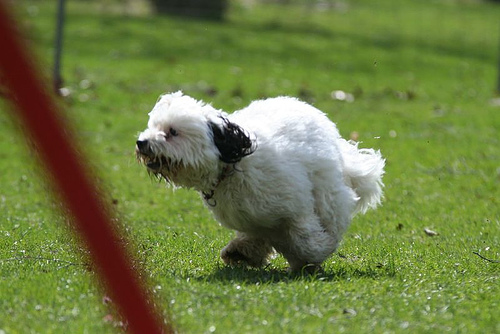

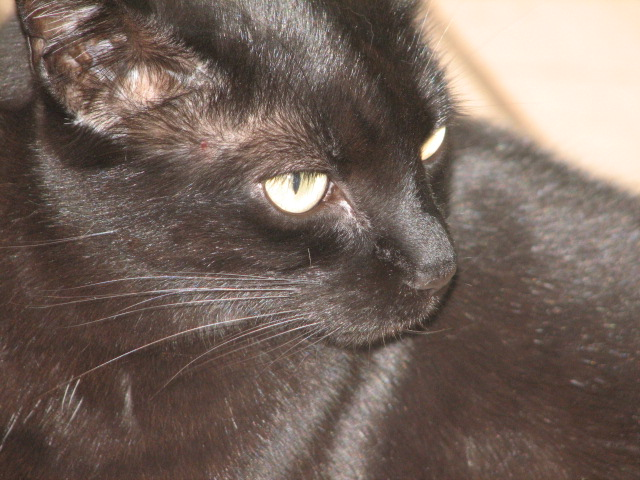

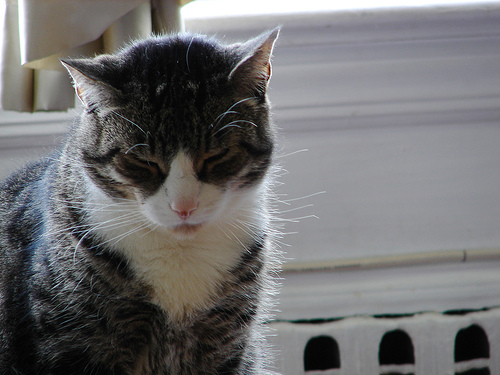

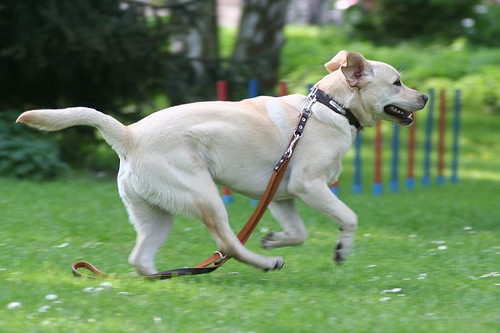

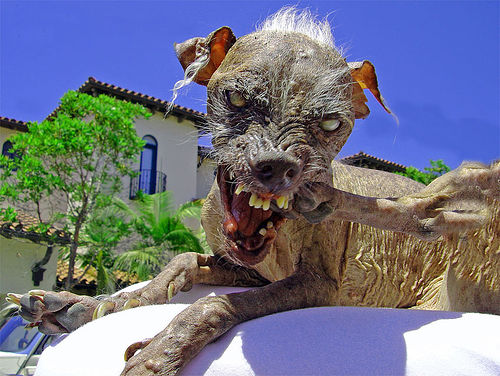

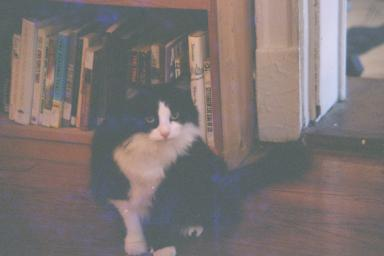

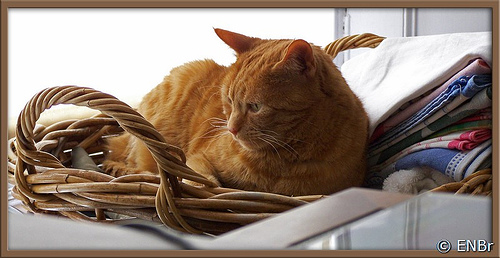

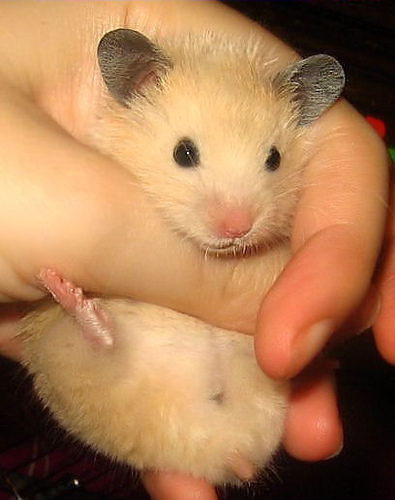

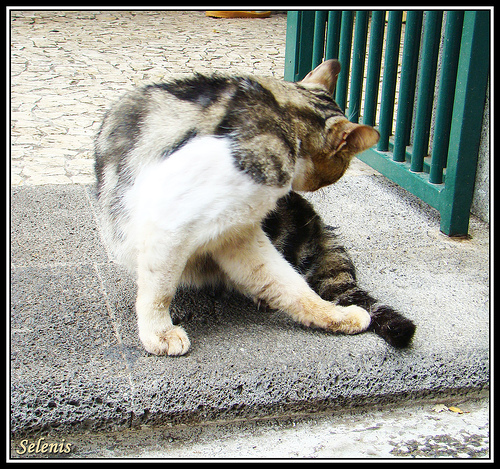

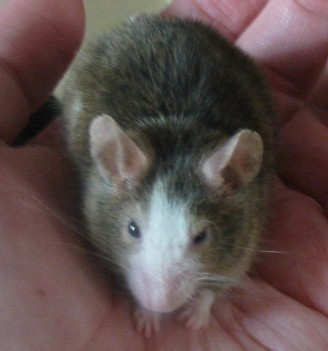

In [3]:
images = frame[:,0].as_data_frame(use_pandas=False)
which = list(random.sample(range(frame.nrow), 10))
sample = [images[x][0] for x in which]
print(sample)
for x in sample:
    display(Image(filename=PATH+x))

Now, we build a classic convolutional neural network, called [LeNet](http://yann.lecun.com/exdb/lenet/)
![LeNet](images/lenet.gif)
![LeNet](images/lenet.jpg)

We'll use a GPU to train such a LeNet model in seconds

In [4]:
!nvidia-smi

Sat Mar 25 10:33:34 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.20                 Driver Version: 375.20                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 980 Ti  Off  | 0000:01:00.0      On |                  N/A |
| 21%   65C    P0    77W / 275W |   1024MiB /  6108MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN X (Pascal)    Off  | 0000:02:00.0     Off |                  N/A |
| 32%   46C    P8    16W / 250W |      2MiB / 12221MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

To build a LeNet image classification model in H2O, simply specify network = "lenet":

In [5]:
model = H2ODeepWaterEstimator(epochs=500, network = "lenet")
model.train(x=[0],y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1490463209672_1


ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 4.881473436039295e-10
RMSE: 2.2094056748454537e-05
LogLoss: 5.386316252321291e-06
Mean Per-Class Error: 0.0
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
90.0,0.0,0.0,0.0,0 / 90
0.0,85.0,0.0,0.0,0 / 85
0.0,0.0,92.0,0.0,0 / 92
90.0,85.0,92.0,0.0,0 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2017-03-25 10:33:35,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2017-03-25 10:33:36,2.121 sec,1027 obs/sec,3.8352060,1,1024.0,0.5757189,1.1374994,0.4232210
,2017-03-25 10:33:41,7.125 sec,18801 obs/sec,421.8726592,110,112640.0,0.0000257,0.0000062,0.0
,2017-03-25 10:33:42,8.097 sec,19281 obs/sec,502.4119850,131,134144.0,0.0000221,0.0000054,0.0


In [6]:
model.deepfeatures(frame, "fullyconnected1_output")

deepfeatures progress: |██████████████████████████████████████████████████| 100%


DF.fullyconnected1_output.C1,DF.fullyconnected1_output.C2,DF.fullyconnected1_output.C3
65.867,39.7906,41.8963
43.3832,31.3177,11.8426
31.5123,14.2099,6.54571
33.9778,16.7934,12.9031
39.8037,0.726722,10.4585
55.2246,14.7118,18.1386
47.7366,31.9268,16.8996
43.7639,10.2864,11.1163
54.152,22.6728,29.2932
22.4691,13.1606,13.7243


If you'd like to build your own LeNet network architecture, then this is easy as well.
In this example script, we are using the 'mxnet' backend. Models can easily be imported/exported between H2O and MXNet since H2O uses MXNet's format for model definition.

In [7]:
def lenet(num_classes):
    import mxnet as mx
    data = mx.symbol.Variable('data')
    # first conv
    conv1 = mx.symbol.Convolution(data=data, kernel=(5,5), num_filter=20)
    tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
    pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
    # second conv
    conv2 = mx.symbol.Convolution(data=pool1, kernel=(5,5), num_filter=50)
    tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
    pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
    # first fullc
    flatten = mx.symbol.Flatten(data=pool2)
    fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
    tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
    # second fullc
    fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=num_classes)
    # loss
    lenet = mx.symbol.SoftmaxOutput(data=fc2, name='softmax')
    return lenet

In [8]:
nclasses = frame[1].nlevels()[0]
lenet(nclasses).save("/tmp/symbol_lenet-py.json")

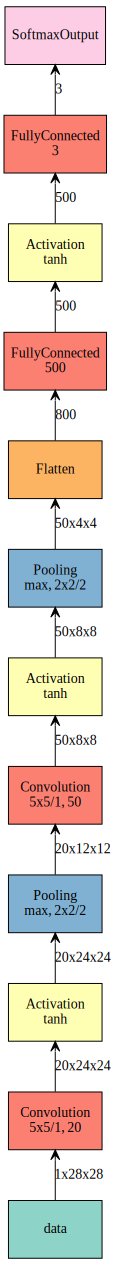

In [9]:
# pip install graphviz
# sudo apt-get install graphviz
import mxnet as mx
import graphviz
mx.viz.plot_network(lenet(3), shape={"data":(1, 1, 28, 28)}, node_attrs={"shape":'rect',"fixedsize":'false'})

In [10]:
model = H2ODeepWaterEstimator(epochs=500, ## early stopping is on by default and might trigger before
                              network_definition_file="/tmp/symbol_lenet-py.json",  ## specify the model
                              image_shape=[28,28],                                  ## provide expected (or matching) image size
                              channels=3)                                           ## 3 for color, 1 for monochrome
model.train(x=[0], y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1490463209672_2


ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 4.1244027467116594e-05
RMSE: 0.006422151311446702
LogLoss: 0.0037224647623094135
Mean Per-Class Error: 0.0
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
90.0,0.0,0.0,0.0,0 / 90
0.0,85.0,0.0,0.0,0 / 85
0.0,0.0,92.0,0.0,0 / 92
90.0,85.0,92.0,0.0,0 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,1.0
2,1.0
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2017-03-25 10:33:44,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2017-03-25 10:33:44,0.128 sec,16786 obs/sec,3.8352060,1,1024.0,0.6503983,1.0714954,0.5730337
,2017-03-25 10:33:49,5.156 sec,22563 obs/sec,429.5430712,112,114688.0,0.0093299,0.0052650,0.0
,2017-03-25 10:33:50,6.060 sec,22428 obs/sec,502.4119850,131,134144.0,0.0064222,0.0037225,0.0


To see how much slower training a convolutional neural net is trained without a GPU, disable the 'gpu' flag. Note that using MKL or other optimized implementations of BLAS can make this difference shrink a lot, but generally a GPU is at least 5x faster than the best CPU implementations for realistic workloads, and often 50x faster or even more.

Instead of training for 500 epochs on the GPU, we'll train for 10 epochs on the CPU.

In [11]:
model = H2ODeepWaterEstimator(epochs=10,
                              network_definition_file="/tmp/symbol_lenet-py.json", 
                              image_shape=[28,28],
                              channels=3,
                              gpu = False)
model.train(x=[0], y=1, training_frame=frame)
model.show()

deepwater Model Build progress: |█████████████████████████████████████████| 100%
Model Details
H2ODeepWaterEstimator :  Deep Water
Model Key:  DeepWater_model_python_1490463209672_3


ModelMetricsMultinomial: deepwater
** Reported on train data. **

MSE: 0.38810377687486314
RMSE: 0.6229797563925036
LogLoss: 0.9865165186143904
Mean Per-Class Error: 0.4536421331817751
Confusion Matrix: vertical: actual; across: predicted



cat,dog,mouse,Error,Rate
31.0,43.0,16.0,0.6555556,59 / 90
7.0,62.0,16.0,0.2705882,23 / 85
9.0,31.0,52.0,0.4347826,40 / 92
47.0,136.0,84.0,0.4569288,122 / 267


Top-3 Hit Ratios: 


k,hit_ratio
1,0.5430711
2,0.8127341
3,1.0


Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_logloss,training_classification_error
,2017-03-25 10:33:50,0.000 sec,None,0.0,0,0.0,nan,nan,nan
,2017-03-25 10:33:53,3.803 sec,298 obs/sec,3.8352060,1,1024.0,0.6550785,1.1130562,0.5730337
,2017-03-25 10:34:01,10.966 sec,298 obs/sec,11.5056180,3,3072.0,0.6229798,0.9865165,0.4569288
